<a href="https://colab.research.google.com/github/kamijoseph/Fashion-Gan/blob/main/fashion_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# generative adversarial network

In [1]:
#!pip install tensorflow matplotlib tensorflow-datasets ipywidgets

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
for gpu in gpus:
  print(gpu)

## dataset

In [5]:
dataset = tfds.load("fashion_mnist", split="train")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.Q1GGDS_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.Q1GGDS_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [6]:
dataset.as_numpy_iterator().next().keys()

dict_keys(['image', 'label'])

## visualizing the dataset and preprocessing


In [7]:
# setting up iterator
data_iterator = dataset.as_numpy_iterator()

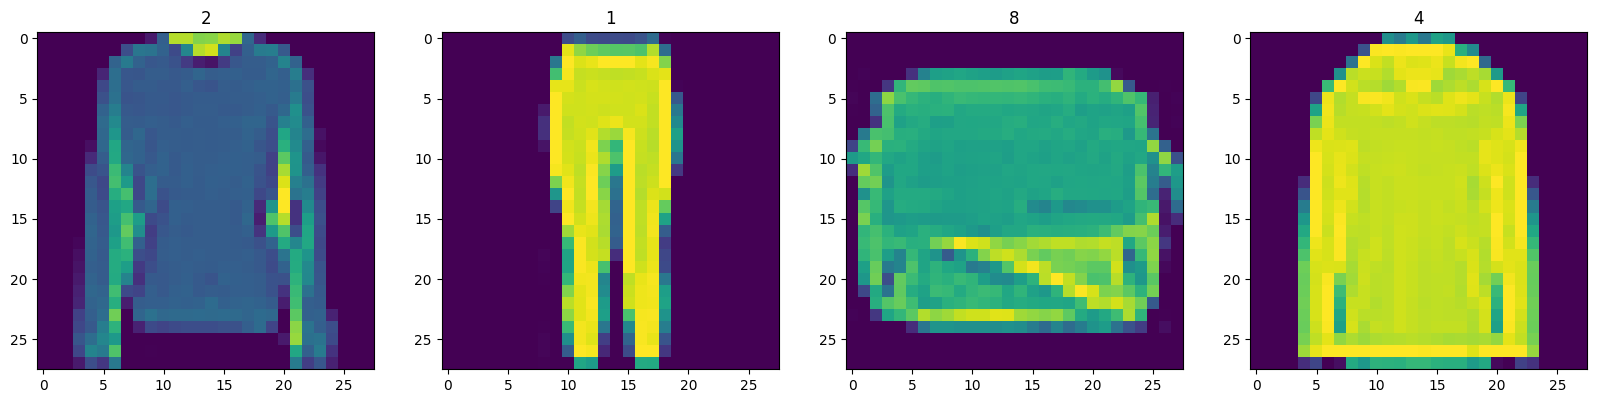

In [8]:
# visualiisng 4 samples
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
  sample = data_iterator.next()
  ax[idx].imshow(np.squeeze(sample["image"]))
  ax[idx].title.set_text(sample["label"])

In [9]:
# scale and return images only function
def scale_images(data):
  image = data["image"]
  return image / 255

In [10]:
# reload dataset
dataset = tfds.load("fashion_mnist", split="train")

# scaling through the scaler function
dataset = dataset.map(scale_images)

# caching dataset for that batch
dataset = dataset.cache()

# shuffling
dataset = dataset.shuffle(60000)

# batch into 128 images per sample
dataset = dataset.batch(128)

# prefetch incase of bottlenecks
dataset = dataset.prefetch(64)

In [11]:
dataset.as_numpy_iterator().next().shape

(128, 28, 28, 1)

## building the neural network

### building the generator

In [12]:
# generator function
def build_generator():
  model = Sequential()

  model.add(Dense(7 * 7 * 128, input_dim=128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7, 7, 128)))

  # upsampling block 1
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding="same"))
  model.add(LeakyReLU(0.2))

  # upsampling block 2
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding="same"))
  model.add(LeakyReLU(0.2))

  # down sampling block 1
  model.add(Conv2D(128, 4, padding="same"))
  model.add(LeakyReLU(0.2))

  # down sampling block 2
  model.add(Conv2D(128, 4, padding="same"))
  model.add(LeakyReLU(0.2))

  # conv layer to get one channel
  model.add(Conv2D(1, 4, padding="same", activation="sigmoid"))

  return model

In [13]:
generator = build_generator()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 6272)           │       809,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 14, 14, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 1)      │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,155,137 (8.22 MB)

 Trainable params: 2,155,137 (8.22 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# generating a test image
img = generator.predict(np.random.randn(4, 128, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


In [16]:
img.shape

(4, 28, 28, 1)

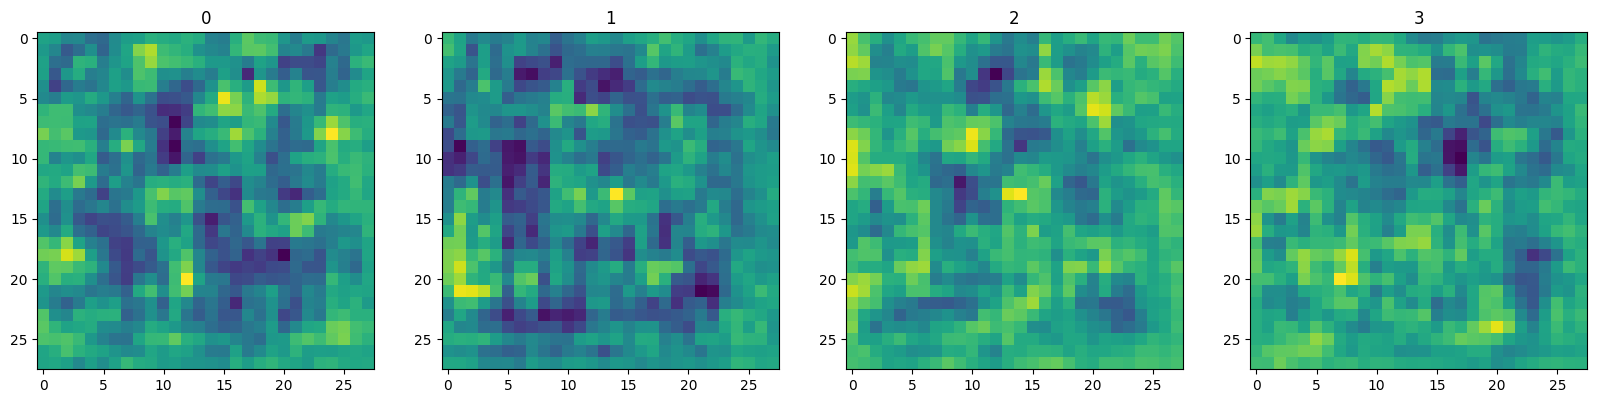

In [17]:
# visualizing the test image
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(img):
  ax[idx].imshow(np.squeeze(img))
  ax[idx].title.set_text(idx)

### building the discriminator

In [18]:
# discriminator function
def build_discriminator():
  model = Sequential()

  # convolution block 1
  model.add(Conv2D(32, 5, input_shape = (28, 28, 1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # convolution block 2
  model.add(Conv2D(64, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # convolution block 3
  model.add(Conv2D(128, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # convolution block 3
  model.add(Conv2D(256, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # flatten and pass to dense
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation="sigmoid"))

  return model

In [19]:
discriminator = build_discriminator()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 20, 20, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        36,865 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,113,345 (4.25 MB)

 Trainable params: 1,113,345 (4.25 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# generating a test image
test = generator.predict(np.random.randn(4, 128, 1))
test.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


(4, 28, 28, 1)

In [22]:
# passing the generated img into the discriminator
discriminator.predict(np.expand_dims(img, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


array([[0.51025903]], dtype=float32)

## constructing the training loop

### losses and optimizers

In [23]:
# optimizers
gen_opt = Adam(learning_rate=0.0001)
disc_opt = Adam(learning_rate=0.00001)

In [24]:
# losses
gen_loss = BinaryCrossentropy()
disc_loss = BinaryCrossentropy()

### building the subclassed model

In [25]:
from tensorflow.python.ops.functional_ops import Gradient
class FashionGan(Model):
  def __init__(self, generator, discriminator, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.generator = generator
    self.discriminator = discriminator

  def compile(self, gen_opt, disc_opt, gen_loss, disc_loss, *args, **kwargs):
    # compiling with base class
    super().compile(*args, **kwargs)

    # loss and optimizers attributes
    self.gen_opt = gen_opt
    self.disc_opt = disc_opt
    self.gen_loss = gen_loss
    self.disc_loss = disc_loss

  def train_step(self, batch):
    # getting the data
    real_images = batch
    fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

    # training the discriminator
    with tf.GradientTape() as d_tape:

      # pass the real and fake images to the discriminator
      yhat_real = self.discriminator(real_images, training=True)
      yhat_fake = self.discriminator(fake_images, training=True)
      yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

      # creating labels for real and fake images
      y_realfake = tf.concat(
          [tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)],
          axis = 0
      )

      # adding some noise to the outputs
      noise_real = 0.15 * tf.random.uniform(tf.shape(yhat_real))
      noise_fake = 0.15 * tf.random.uniform(tf.shape(yhat_fake))
      y_realfake += tf.concat(
          [noise_real, noise_fake],
          axis = 0
      )

      # calculate loss --> binary crossentropy
      total_disc_loss = self.disc_loss(y_realfake, yhat_realfake)

    # applying backpropagation --> neural network learning
    disc_grad = d_tape.gradient(
        total_disc_loss,
        self.discriminator.trainable_variables
    )
    self.disc_opt.apply_gradients(zip(
        disc_grad,
        self.discriminator.trainable_variables
    ))

    # trainng the generator
    with tf.GradientTape() as g_tape:

      # generate some new images
      gen_images = self.generator(tf.random.normal((128, 128, 1)), training=True)

      # creating predicted labels
      predicted_labels = self.discriminator(gen_images, training=False)

      # calculate loss
      total_gen_loss = self.gen_loss(
          tf.zeros_like(predicted_labels),
          predicted_labels
      )

    # apply backpropagation
    gen_grad = g_tape.gradient(
        total_gen_loss,
        self.generator.trainable_variables
    )
    self.gen_opt.apply_gradients(zip(
        gen_grad,
        self.generator.trainable_variables
    ))

    return {
        "disc_loss": total_disc_loss,
        "gen_loss": total_gen_loss
    }

In [26]:
# instantiating the class
fashgan = FashionGan(generator, discriminator)

# compiling the model
fashgan.compile(gen_opt, disc_opt, gen_loss, disc_loss)

### building a callback

In [27]:
# model monitor class
class ModelMonitor(Callback):
  def __init__(self, num_img=3, latent_dim=128):
    self.num_img = num_img
    self.latent_dim = latent_dim

  def on_epoch_end(self, epoch, logs=None):
    random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
    generated_images = self.model.generator(random_latent_vectors)
    generated_images *= 255
    generated_images.numpy()
    for i in range(self.num_img):
      img = array_to_img(generated_images[i])
      img.save(os.path.join(f"generated_img_{epoch}_{i}.png"))

### training

In [28]:
# recomended 2000 epochs
hist = fashgan.fit(dataset, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20
 30/469 ━━━━━━━━━━━━━━━━━━━━ 3:07:24 26s/step - disc_loss: 0.6659 - gen_loss: 0.6983

KeyboardInterrupt: 

### review perfomance

In [ ]:
hist.history

In [ ]:
plt.suptitle("Loss")
plt.plot(hist.history["disc_loss"], label="disc_loss")
plt.plot(hist.history["gen_loss"], label="gen_loss")
plt.legend()
plt.show()